# Santa Claus the Engineer!

By: Megan Ku and Katie Gosbee

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Question:

Suppose Santa is trying to speed up the already quick present-giving process on Christmas Eve. Instead of going to the roof of every building on Olin's campus, he decides to land on West Hall and launch all his presents to the tops of the other four buildings. He has a launcher that can launch presents at any velocity and angle that he desires (because Santa is an engineer). He is designing his launcher and needs to know which is a reasonable design that'll get the job done. He is debating between a launcher that uses a spring and a mechanical launcher with motors (refer to images below).


After finding the angle and final velocity that will optimize Santa's needed force to launch his presents to all the other campus buildings, should Santa use a spring powered launcher or a mechanical launcher?

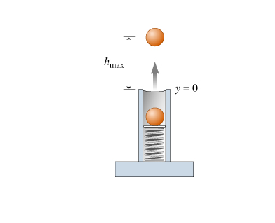

Spring Launcher


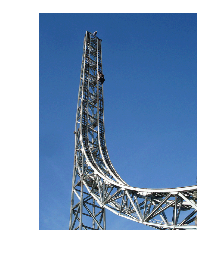

Mechanical Launcher


In [2]:
plt.figure(figsize=(4,4))
myImage = mpimg.imread("Launcher1.png")
myImage = plt.imshow(myImage)
plt.axis('off')
plt.show()
print('Spring Launcher')
plt.figure(figsize=(4,4))
myImage = mpimg.imread("Launcher2.png")
myImage = plt.imshow(myImage)
plt.axis('off')
plt.show()
print('Mechanical Launcher')

This mechanical launcher involves motors and gears accelerating a platform, which the present is resting on, up the track and when the track runs out, the present continues its motion forward due to momentum.

## Setting up the Simulation

In [3]:
#define units

m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
feet = UNITS.feet
inch = UNITS.inch
degree = UNITS.degree
N = UNITS.newton;

Here are the heights of Olin's five buildings, according to the building plans. We decided to set the elevation of West Hall as our origin to provide clarity.  We made sure that the buildings' heights are based off of the elevation levels, using the building plans.

The distances we found are based off of the points on the buildings where we identified the elevation.  Since there were no identifiable "chimneys" on Olin's buildings, we assume that any point on the roof would be considered a succesful delivery. From there we picked specific points on the roofs of the buildings and measured elevation and distance from those points.

*Note: any variables pertaining to a building are assigned as "variable_building"*

In [4]:
height_WH = (229.031*feet + 1.625*inch).to(m) 

height_EH = (224.306*feet).to(m) - height_WH 
height_CC = (257.33*feet).to(m) - height_WH 
height_MH = (243.33*feet).to(m) - height_WH 
height_AC =  (262*feet).to(m) - height_WH 

<Quantity(10.007676200000006, 'meter')>

... and the approximate distances between West Hall and the other four buildings (estimated using Google Maps).

In [5]:
to_EH = 75.84*m
to_MH = 70.04*m
to_AC = 121.94*m
to_CC = 28.48*m;

Now we need to create "params" and our System variable.  We'll start off by assuming Santa's launcher launches presents at a speed of 40m/s.

We decided to use cube-shaped presents that were 1ft in length.  We used Amazon to get an estimate of the size of the most popular presents were for 2018.

We also assume that there is no wind blowing and that there are no other projectiles or obstacles in the way of the trajectory path, like snow fall.

In [6]:
#create parameters
params = Params(x = 0 * m, #Position of present at the start
                y = 0 * m,
                g = 9.81 * m/s**2,
                mass = 1.0206 * kg, #Mass of the present
                height = 0.3048 * m,#Height of present (1foot = 0.3048)
                length = 0.3048 * m, #of present
                width = 0.3048 * m, #of present
                rho = 1.2 * kg/m**3, #mass density of air
                C_d = 0.8, #drag coefficient of a box
                angle = 45 * degree, #initial guess of the optimal angle, this will change
                velocity = 40 * m / s, #initial guess of optimal velocity, this will change
                t_end = 100*s, #this ends the simulation if it runs up to 100 seconds
                h_end = 0*m, #this will change based on the building the present is being launched to
                d_end = 10*m)

,values
x,0 meter
y,0 meter
g,9.81 meter / second ** 2
mass,1.0206 kilogram
height,0.3048 meter
length,0.3048 meter
width,0.3048 meter
rho,1.2 kilogram / meter ** 3
C_d,0.8
angle,45 degree


Now, we'll write functions that will create the system object, calculate the force of drag on the present, and compute the derivates of the state variables (like velocity and acceleration).

In [7]:
#create our system object

def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               height, width, length, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from dimensions
    area = height*length
    
    return System(params, init=init, area=area)

We also wrote drag and slope functions to update forces as the present moved through the air.

Drag force is calculated using the equation $(\rho * v^2 * C_d * \frac{area}{2})$.  We add a negative sign in front
of the equation to make the force in the opposite direction of velocity.

*slope_func* calculates the current net acceleration of the system.  Using the equation $F=ma$ and the force due to gravity, $g$, the function updates the individual accelerations for gravity and drag before summing them. We assume that the present doesn't rotate to simplify the model.  We wanted to focus mainly on drag, similar to the Manny Ramirez problem. 

In [8]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [9]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

Next, we implement the measured data of the buildings and figure out what the optimal speed and angle are for Santa if he launched presents from West Hall to the other four buildings on campus. First, we'll create new *params* objects for each building in relation to West Hall.

In [10]:
params_EH = Params(params, h_end=height_EH, d_end=to_EH);
params_MH = Params(params, h_end=height_MH, d_end=to_MH);
params_AC = Params(params, h_end=height_AC, d_end=to_AC);
params_CC = Params(params, h_end=height_CC, d_end=to_CC);

We created *event_func*, which stops the solver when the projectile reaches the building. Then we wrote *height_func*, which calculates the height of the projectile when the it reaches the building.

In [11]:
def event_func(state, t, system):
    """Stop when the x coordinate is zero.
        When the object reaches the desired horizontal distance, the solver will end.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate
    """
    unpack(system)
    x, y, vx, vy = state
    return x-d_end

def height_func(angle, params):  
    """Computes height for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: height in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    y_dist = get_last_value(results.y) * m
    return y_dist

In [12]:
#testing the height function to see if it works using hand-calculated values
height_func(38.59*degree, Params(params_EH, velocity = 48.9*m/s))

<Quantity(-1446.9820094592367, 'meter')>

We then created an *error_func* to calculate the difference between the final height of the projectile and the height of the building.  Since we wanted to save the measure of the angle at which the projectile was launched without explicitly returning it, we assign the angle measure to the **global** variable *opt_angle*. 

In [13]:
opt_angle = 45*degree
'''
opt_angle is a global variable. 

We are using it to temporarily store the optimal angle value so we can run the simulation of the present's trajectory
    after we solve for the optimal velocity.
'''

def error_func(v, params):
    """Finds the difference between the current height and the building height.
    
    v: Velocity variable
    params: Params object
    
    returns: difference in height in meters
    """
    
    this_params = Params(params, velocity=v)
    optimal_height = max_bounded(height_func, [0,90], this_params)
    global opt_angle
    opt_angle = optimal_height.x*degree
    height = optimal_height.fun
    return height - params.h_end

## Calculating Optimal Angle and Velocity

Now we calculate the optimal angle and velocity using *fsolve*.

### East Hall Calculations:

In [14]:
res = fsolve(error_func, 45*m/s, params_EH);
v_EH = res[0]*m/s
angle_EH = opt_angle
print(v_EH, angle_EH)

217.18403596400898 meter / second 22.726441888911587 degree


In [15]:
params_EH = Params(params_EH, velocity=v_EH, angle=angle_EH)
system_EH = make_system(params_EH);
error_func(params_EH.velocity, params_EH)

<Quantity(2.3872459564699966e-11, 'meter')>

In [16]:
resultsEH, detailsEH = run_ode_solver(system_EH, slope_func, method="RK45",max_step = 0.5*s, events = event_func)
print(resultsEH)

                  x          y          vx         vy
0.000000   0.000000   0.000000  200.321845  83.905089
0.000007   0.001304   0.000546  200.309468  83.899841
0.000072   0.014344   0.006008  200.185778  83.847395
0.000723   0.144294   0.060435  198.957240  83.326456
0.007234   1.401615   0.586817  187.453949  78.446663
0.046657   7.738171   3.231655  138.884751  57.784582
0.107788  14.875865   6.184938   99.134809  40.732408
0.200846  22.534880   9.294061   69.126861  27.628334
0.339704  30.459453  12.377418   47.714467  17.919542
0.546715  38.589729  15.244630   32.770001  10.594698
0.858015  46.970001  17.533381   22.441891   4.682866
1.337712  55.778488  18.374943   15.252185  -0.768118
1.837712  62.346584  16.929827   11.352171  -4.840740
2.337712  67.336925  13.675684    8.739253  -8.045839
2.837712  71.179968   9.012659    6.706473 -10.479220
3.337712  74.108497   3.317346    5.067754 -12.190483
3.718841  75.840000  -1.509880    4.050091 -13.089656



We can see it took about 4 seconds for the projectile to get from the roof of West Hall to the roof of East Hall. We can then plot the path that the present takes.


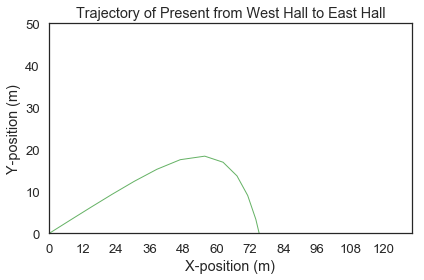

In [17]:
plt.xticks(np.linspace(0, 120, 11, endpoint=True))
plt.yticks(np.linspace(0,100,11, endpoint=True))
plt.xlim(0,130)
plt.ylim(0,50)

plot(resultsEH.x,resultsEH.y, color= "green", linewidth=1.0)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to East Hall',
         legend=False)

East Hall is at a slightly lower elevation than West Hall, so our graph seems appropriate.

Now that we know that we were successful with launching presents to East Hall, we can repeat the process with the three other buildings on campus.

### Campus Center (CC) Calculations

In [18]:
res2 = fsolve(error_func, 45*m/s, params_CC);
v_CC = res2[0]*m/s
angle_CC = opt_angle
print(v_CC, angle_CC)

39.02156078921581 meter / second 43.5532874248437 degree


In [19]:
params_CC = Params(params_CC, velocity=v_CC, angle=angle_CC)
system_CC = make_system(params_CC);
error_func(params_CC.velocity, params_CC)

<Quantity(2.959055223072937e-11, 'meter')>

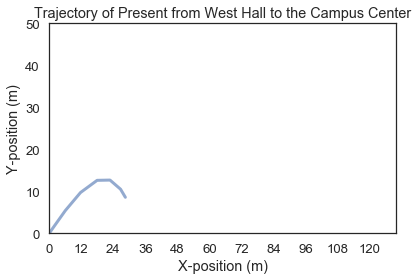

In [20]:
resultsCC, detailsCC = run_ode_solver(system_CC, slope_func, method="RK45", max_step=0.5*s, events = event_func)
detailsCC.message
plt.xticks(np.linspace(0, 120, 11, endpoint=True))
plt.yticks(np.linspace(0,100,11, endpoint=True))
plt.xlim(0,130)
plt.ylim(0,50)
plot(resultsCC.x, resultsCC.y)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to the Campus Center',
         legend=False)

### Milas Hall (MH) Calculations

In [21]:
res3 = fsolve(error_func, 45*m/s, params_MH);
v_MH = res3[0]*m/s
angle_MH = opt_angle
print(v_MH, angle_MH)

185.44591293807227 meter / second 26.131223080453662 degree


In [22]:
params_MH = Params(params_MH, velocity=v_MH, angle=angle_MH)
system_MH = make_system(params_MH)
error_func(params_MH.velocity, params_MH)

<Quantity(-5.950795411990839e-13, 'meter')>

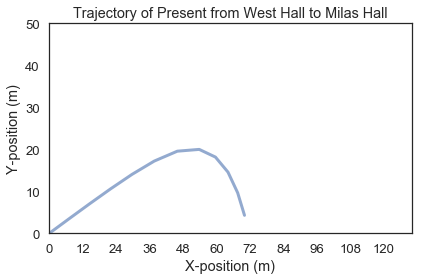

In [23]:
resultsMH, detailsMH = run_ode_solver(system_MH, slope_func, method="RK45", max_step=0.5*s, events = event_func)
detailsMH.message
plt.xticks(np.linspace(0, 120, 11, endpoint=True))
plt.yticks(np.linspace(0,100,11, endpoint=True))
plt.xlim(0,130)
plt.ylim(0,50)
plot(resultsMH.x, resultsMH.y)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to Milas Hall',
         legend=False)

### Academic Center (AC) Calculations

In [24]:
res4 = fsolve(error_func, 45*m/s, params_AC);
v_AC = res4[0]*m/s
angle_AC = opt_angle
print(v_AC, angle_AC)

2421.2023030895375 meter / second 26.447008605830504 degree


C:\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [25]:
params_AC = Params(params, velocity=v_AC, angle=angle_AC, h_end=height_AC, d_end=to_AC)
system_AC = make_system(params_AC)
error_func(params_AC.velocity, params_AC)

<Quantity(22.74898837724622, 'meter')>

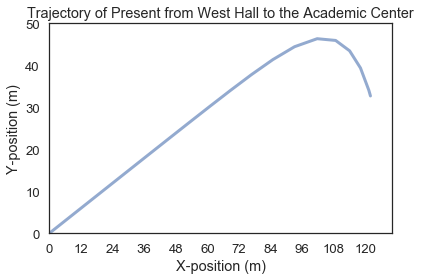

In [26]:
resultsAC, detailsAC = run_ode_solver(system_AC, slope_func, method="RK45", max_step=0.5*s, events = event_func)
detailsAC.message
plt.xticks(np.linspace(0, 120, 11, endpoint=True))
plt.yticks(np.linspace(0,100,11, endpoint=True))
plt.xlim(0,130)
plt.ylim(0,50)

plot(resultsAC.x, resultsAC.y)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to the Academic Center',
         legend=False)

Here's an overlaying plot of all the graphs:

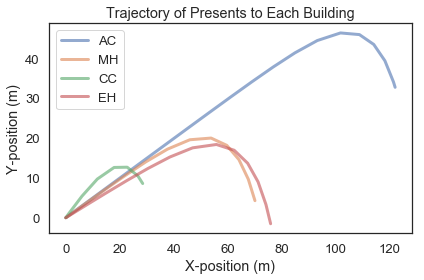

In [27]:
plot(resultsAC.x, resultsAC.y, label='AC')
plot(resultsMH.x, resultsMH.y, label='MH')
plot(resultsCC.x, resultsCC.y, label='CC')
plot(resultsEH.x,resultsEH.y, label='EH')
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Presents to Each Building',
         legend=True)

## Calculating Forces Needed

Now that we have calculated the respective velocity and corresponding angle for each building, we'll find the force each launcher needs to launch the presents at the desired velocities.

Some assumptions we make are:

- Friction is negligible (we do this because friction wouldn't affect the launcher $that$ much, it also would affect both situations the same amount, so the ratio of forces needed will stay true)
- Force of drag doesn't exist on the launcher (this simplifies the equations and also wouldn't have a huge affect on the force needed)

#### Explanation of Functions:

We first create a function that will calculate the force needed to push the spring back, given the final velocity. It uses the equation: $ PE = \frac{1}{2} k x^2 $, $ KE = \frac{1}{2}mv^2 $, and $ F = -kx $. 

- In the first equation, $PE$ stands for potential energy; in this case, it's the potential energy of a spring. $k$ stands for the spring constant, and $x$ stands for the displacement of the spring.

- In the second equation, $KE$ stands for kinetic energy; this is the energy an object has while in motion. $m$ stands for the mass of the object, and $v$ stands for the velocity, in this case $v$ will be the velocity we want the present to launch at.

- In the third equation, $F$ stands for force, $k$ stands for the spring constant (which changes based on the type of spring), and $x$ stands for the displacement from the spring's position of rest.

We use the conservation of energy to say that $U=KE$ and then we solve for k to tell use what the best type of spring (meaning the soring that will need the least amount of force in this situation). After we find $k$, we plug it in to the third equation and solve the force needed to move the spring back.


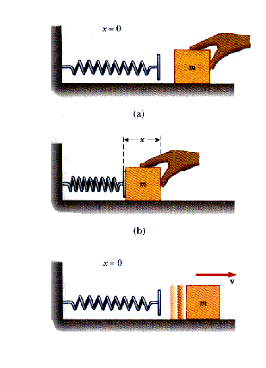

Diagram showing elastic potential energy from http://www.ux1.eiu.edu/~cfadd/1350/08PotEng/Exmpl.html


In [28]:
plt.figure(figsize=(6,6))
myImage = mpimg.imread("Spring Energy Example.png")
myImage = plt.imshow(myImage)
plt.axis('off')
plt.show()
print('Diagram showing elastic potential energy from http://www.ux1.eiu.edu/~cfadd/1350/08PotEng/Exmpl.html')

In [29]:
def compute_force_spring(params):
    """Calculates force to push spring in imaginary present-launcher.
    
    params: Params object
    
    returns: force
    """
    unpack(params)

    k_constant = (mass * velocity**2) / ((4)*m**2) #4 stands for the length that the spring will extend
    force_to_push_spring = k_constant * ((4)*m) # f=kx
    return force_to_push_spring

We now write a funtion for calculating the force the track launcher needs to accelerate the package, given the length of the track. We use the equation: $ v^2 = v_0^2 + 2a(x-x_0) $ and solve for $a$. 

Once we find $a$, we use the classic $ F = m*a $ in order to calculate the constant force needed to push the present in the given length of the track. 

In [30]:
def compute_force_track(params):
    unpack(params)
    accel = velocity**2/(2*4*m) #4 stands for the length of the track that will push the present forward 
    force = mass * accel
    return force

## Calculations for Each Building:

#### To East Hall

In [31]:
force_EH_spring = compute_force_spring(params_EH).to(N)/2
force_to_EH_track = compute_force_track(params_EH).to(N)
print('Spring launcher force (per arm): ' + str(round(force_EH_spring,2)))
print('Track launcher force: ' +str(round(force_to_EH_track,2)))

Spring launcher force (per arm): 24070.29 newton
Track launcher force: 6017.57 newton


#### To Milas Hall

In [32]:
force_MH_spring = compute_force_spring(params_MH).to(N)/2
force_to_MH_track = compute_force_track(params_MH).to(N)
print('Spring launcher force (per arm): ' + str(round(force_MH_spring,2)))
print('Track launcher force: ' +str(round(force_to_MH_track,2)))

Spring launcher force (per arm): 17549.31 newton
Track launcher force: 4387.33 newton


#### To Campus Center

In [33]:
force_CC_spring = compute_force_spring(params_CC).to(N)/2
force_to_CC_track = compute_force_track(params_CC).to(N)
print('Spring launcher force (per arm): ' + str(round(force_CC_spring,2)))
print('Track launcher force: ' +str(round(force_to_CC_track,2)))

Spring launcher force (per arm): 777.02 newton
Track launcher force: 194.26 newton


#### To Academic Center

In [34]:
force_AC_spring = compute_force_spring(params_AC).to(N)/2
force_to_AC_track = compute_force_track(params_AC).to(N)
print('Spring launcher force (per arm): ' + str(round(force_AC_spring,2)))
print('Track launcher force: ' +str(round(force_to_AC_track,2)))

Spring launcher force (per arm): 2991491.17 newton
Track launcher force: 747872.79 newton


## Conclusion:

As can be seen by the results, the track (mechanical) launcher required less force to achieve the same velocity as the spring launcher.  Therefore, if Santa were to build a launcher, we'd suggest he build a mechanical one.  All in all, it might be better for Santa to just fly over all the buildings, seeing as he's mastered travelling faster than the speed of sound to deliver presents.

https://www.physlink.com/Fun/IsThereSanta.cfm